# IE Predictor Model

In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle

from config import driver, username, password, host, port, database
from sqlalchemy import create_engine

In [2]:
connection_string = f"{driver}://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)
connection = engine.connect()

In [3]:
# QuestionsListDF = pd.read_sql_table('questionslist', connection)
# QuestionsListDF.head()

In [4]:
# pd.options.display.max_columns = 300
# pd.options.display.max_columns = 100
pd.options.display.max_columns = 20

In [5]:
# local csv file read

QuestionnaireDF = pd.read_csv(Path('../resources/data.csv'), delimiter='\t')
QuestionnaireDF.rename(columns ={'country':'COUNTRY', 
                                 'dateload':'DATELOAD',
                                 'introelapse':'INTROELAPSE',
                                 'testelapse':'TESTELAPSE',
                                 'surveyelapse':'SURVEYELAPSE',
                                 'gender':'GENDER',
                                 'engnat':'ENGNAT',
                                 'age':'AGE',
                                 'IE':'INTROVERT_EXTROVERT'}, inplace=True)
QuestionnaireDF

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q91E,COUNTRY,DATELOAD,INTROELAPSE,TESTELAPSE,SURVEYELAPSE,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,51,7107,3,91,2522,1,56,6180,2,...,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3
1,5,39,6354,5,13,3092,1,12,5243,5,...,10409,AU,2019-02-20 17:46:32,21,467,15,1,2,25,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,2691,BR,2019-02-20 18:10:24,56,306,17,1,2,19,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,3697,CZ,2019-02-20 18:16:21,2,287,14,1,1,23,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,1662,CA,2019-02-20 18:21:49,2,325,12,1,1,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,46,1328,4,82,3214,4,43,3360,5,...,3495,US,2019-08-19 12:54:22,8,299,14,2,1,53,1
7184,2,5,8786,5,24,2233,5,10,10387,5,...,6088,CA,2019-08-19 13:10:30,25,498,20,1,1,20,1
7185,3,29,6618,5,44,2393,4,58,5768,5,...,3425,BY,2019-08-19 13:29:47,3,326,17,2,2,28,1
7186,4,15,8321,2,18,6179,5,60,5037,1,...,17416,CA,2019-08-19 15:19:35,3,414,23,2,1,19,1


In [6]:
# Read from AWS

# QuestionnaireDF = pd.read_sql_table('questionnaire', connection)
# QuestionnaireDF.head()

## Preprocessing - Provide output as CleansedDF

In [7]:
# filtering the rows that are not contributing to Classification values "Introvert/Extrovert/Ambivert" 

QuestionnaireDF = QuestionnaireDF.loc[QuestionnaireDF['INTROVERT_EXTROVERT'] != 0]
QuestionnaireDF

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q91E,COUNTRY,DATELOAD,INTROELAPSE,TESTELAPSE,SURVEYELAPSE,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,51,7107,3,91,2522,1,56,6180,2,...,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3
1,5,39,6354,5,13,3092,1,12,5243,5,...,10409,AU,2019-02-20 17:46:32,21,467,15,1,2,25,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,2691,BR,2019-02-20 18:10:24,56,306,17,1,2,19,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,3697,CZ,2019-02-20 18:16:21,2,287,14,1,1,23,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,1662,CA,2019-02-20 18:21:49,2,325,12,1,1,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,46,1328,4,82,3214,4,43,3360,5,...,3495,US,2019-08-19 12:54:22,8,299,14,2,1,53,1
7184,2,5,8786,5,24,2233,5,10,10387,5,...,6088,CA,2019-08-19 13:10:30,25,498,20,1,1,20,1
7185,3,29,6618,5,44,2393,4,58,5768,5,...,3425,BY,2019-08-19 13:29:47,3,326,17,2,2,28,1
7186,4,15,8321,2,18,6179,5,60,5037,1,...,17416,CA,2019-08-19 15:19:35,3,414,23,2,1,19,1


In [8]:
# Selecting only features that are considered to be important for training the model

QuestionnaireDF = QuestionnaireDF.drop(columns=['COUNTRY', 'DATELOAD', 'INTROELAPSE', 'TESTELAPSE', 'SURVEYELAPSE'])
QuestionnaireDF.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q90A,Q90I,Q90E,Q91A,Q91I,Q91E,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,51,7107,3,91,2522,1,56,6180,2,...,3,40,4648,3,35,4609,2,1,23,3
1,5,39,6354,5,13,3092,1,12,5243,5,...,4,28,3884,3,1,10409,1,2,25,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,1,87,1759,1,19,2691,1,2,19,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,3,15,2345,3,23,3697,1,1,23,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,5,86,6413,5,69,1662,1,1,18,2


In [9]:
# Validating the data in the selected features

QuestionnaireDF['AGE'].sort_values().unique()

array([     14,      15,      16,      17,      18,      19,      20,
            21,      22,      23,      24,      25,      26,      27,
            28,      29,      30,      31,      32,      33,      34,
            35,      36,      37,      38,      39,      40,      41,
            42,      43,      44,      45,      46,      47,      48,
            49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,
            63,      64,      65,      66,      67,      68,      69,
            70,      71,      72,      73,      75,      77,      78,
            79,      81,      90,     255,    1979,    1983,    1990,
          1991,    1996,    1999,    2003, 8675309], dtype=int64)

In [10]:
# Define variables for cleaning age feature. Drop rows with age above max_age

max_age = 100
# Age: Clean up invalid rows where age is above max_age
age_range = (QuestionnaireDF['AGE'] < max_age)
QuestionnaireDF = QuestionnaireDF.loc[age_range]

In [11]:
# DF values after the age clean up

QuestionnaireDF['AGE'].sort_values().unique()

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 81, 90],
      dtype=int64)

In [12]:
#  Selecting only the response columns from the dataframe. Ignoring the columns with Question sequence and response time.

ColumnsList = QuestionnaireDF.columns.to_list()

surveyResponseColumnsList = []
for column in ColumnsList:
    if (column[0] == 'Q' and column[-1] == 'A'):
        surveyResponseColumnsList.append(column)

surveyResponseColumnsList

['Q1A',
 'Q2A',
 'Q3A',
 'Q4A',
 'Q5A',
 'Q6A',
 'Q7A',
 'Q8A',
 'Q9A',
 'Q10A',
 'Q11A',
 'Q12A',
 'Q13A',
 'Q14A',
 'Q15A',
 'Q16A',
 'Q17A',
 'Q18A',
 'Q19A',
 'Q20A',
 'Q21A',
 'Q22A',
 'Q23A',
 'Q24A',
 'Q25A',
 'Q26A',
 'Q27A',
 'Q28A',
 'Q29A',
 'Q30A',
 'Q31A',
 'Q32A',
 'Q33A',
 'Q34A',
 'Q35A',
 'Q36A',
 'Q37A',
 'Q38A',
 'Q39A',
 'Q40A',
 'Q41A',
 'Q42A',
 'Q43A',
 'Q44A',
 'Q45A',
 'Q46A',
 'Q47A',
 'Q48A',
 'Q49A',
 'Q50A',
 'Q51A',
 'Q52A',
 'Q53A',
 'Q54A',
 'Q55A',
 'Q56A',
 'Q57A',
 'Q58A',
 'Q59A',
 'Q60A',
 'Q61A',
 'Q62A',
 'Q63A',
 'Q64A',
 'Q65A',
 'Q66A',
 'Q67A',
 'Q68A',
 'Q69A',
 'Q70A',
 'Q71A',
 'Q72A',
 'Q73A',
 'Q74A',
 'Q75A',
 'Q76A',
 'Q77A',
 'Q78A',
 'Q79A',
 'Q80A',
 'Q81A',
 'Q82A',
 'Q83A',
 'Q84A',
 'Q85A',
 'Q86A',
 'Q87A',
 'Q88A',
 'Q89A',
 'Q90A',
 'Q91A']

In [13]:
# elapsedTimeColumnsList = []
# for column in ColumnsList:
#     if (column[0] == 'Q' and column[-1] == 'E'):
#         elapsedTimeColumnsList.append(column)
        
# elapsedTimeColumnsList   

In [14]:
# elapsedTimeColumnsDF = QuestionnaireDF[['Q1E', 'Q2E', 'Q3E', 'Q4E', 'Q5E']]
# elapsedTimeColumnsDF = QuestionnaireDF[elapsedTimeColumnsList]
# elapsedTimeColumnsDF.head()

In [15]:
# 1 Minute = 60 Seconds = 60,000 Milliseconds
# Identify all rows that have atleast one response time more than 1 minute

# elapsedTimeColumnsDF['Q1E'].loc[lambda x : x > 60000]
# outliersDF = elapsedTimeColumnsDF[elapsedTimeColumnsDF.gt(60000).any(axis=1)]
# outliersDF

In [16]:
# outliersinSecondsDF=outliersDF/1000
# outliersinSecondsDF

In [13]:
#Final Cleansed DF for Machine Learning
CleansedDF = QuestionnaireDF[surveyResponseColumnsList].copy()
CleansedDF['GENDER'] = QuestionnaireDF['GENDER']
CleansedDF['ENGNAT'] = QuestionnaireDF['ENGNAT']
CleansedDF['AGE'] = QuestionnaireDF['AGE']
CleansedDF['INTROVERT_EXTROVERT'] = QuestionnaireDF['INTROVERT_EXTROVERT']

CleansedDF

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,3,1,2,3,2,3,3,4,5,...,4,2,5,4,3,3,2,1,23,3
1,5,5,1,5,2,2,5,2,1,3,...,1,3,4,4,4,3,1,2,25,2
2,3,4,5,3,4,5,5,5,5,5,...,4,5,3,2,1,1,1,2,19,1
3,5,2,1,1,5,5,5,4,4,2,...,3,5,4,4,3,3,1,1,23,1
4,1,2,1,1,3,3,5,1,3,4,...,3,1,2,5,5,5,1,1,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,4,4,5,5,4,4,4,4,4,...,4,3,4,2,5,4,2,1,53,1
7184,2,5,5,5,4,4,5,5,4,3,...,5,4,3,1,3,2,1,1,20,1
7185,3,5,4,5,5,5,4,5,5,5,...,4,5,3,1,1,1,2,2,28,1
7186,4,2,5,1,5,1,5,4,5,1,...,4,1,1,4,5,2,2,1,19,1


## Machine learning 

In [14]:
CleansedDF.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,GENDER,ENGNAT,AGE,INTROVERT_EXTROVERT
0,5,3,1,2,3,2,3,3,4,5,...,4,2,5,4,3,3,2,1,23,3
1,5,5,1,5,2,2,5,2,1,3,...,1,3,4,4,4,3,1,2,25,2
2,3,4,5,3,4,5,5,5,5,5,...,4,5,3,2,1,1,1,2,19,1
3,5,2,1,1,5,5,5,4,4,2,...,3,5,4,4,3,3,1,1,23,1
4,1,2,1,1,3,3,5,1,3,4,...,3,1,2,5,5,5,1,1,18,2


In [15]:
X = CleansedDF.drop(columns=['INTROVERT_EXTROVERT'])
X

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,GENDER,ENGNAT,AGE
0,5,3,1,2,3,2,3,3,4,5,...,1,4,2,5,4,3,3,2,1,23
1,5,5,1,5,2,2,5,2,1,3,...,2,1,3,4,4,4,3,1,2,25
2,3,4,5,3,4,5,5,5,5,5,...,5,4,5,3,2,1,1,1,2,19
3,5,2,1,1,5,5,5,4,4,2,...,5,3,5,4,4,3,3,1,1,23
4,1,2,1,1,3,3,5,1,3,4,...,1,3,1,2,5,5,5,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,1,4,4,5,5,4,4,4,4,4,...,3,4,3,4,2,5,4,2,1,53
7184,2,5,5,5,4,4,5,5,4,3,...,4,5,4,3,1,3,2,1,1,20
7185,3,5,4,5,5,5,4,5,5,5,...,5,4,5,3,1,1,1,2,2,28
7186,4,2,5,1,5,1,5,4,5,1,...,1,4,1,1,4,5,2,2,1,19


In [16]:
y = CleansedDF['INTROVERT_EXTROVERT']
y

0       3
1       2
2       1
3       1
4       2
       ..
7183    1
7184    1
7185    1
7186    1
7187    1
Name: INTROVERT_EXTROVERT, Length: 7153, dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_roc_curve, roc_curve, roc_auc_score

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [19]:
print(f"X_Train Shape: {X_train.shape} \nX_Train Columns: {X_train.columns}")
print(f"X_Train Shape: {X_test.shape} \nX_Train Columns: {X_test.columns}")

X_Train Shape: (4792, 94) 
X_Train Columns: Index(['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A',
       'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A',
       'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A',
       'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A',
       'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A', 'Q43A', 'Q44A', 'Q45A', 'Q46A',
       'Q47A', 'Q48A', 'Q49A', 'Q50A', 'Q51A', 'Q52A', 'Q53A', 'Q54A', 'Q55A',
       'Q56A', 'Q57A', 'Q58A', 'Q59A', 'Q60A', 'Q61A', 'Q62A', 'Q63A', 'Q64A',
       'Q65A', 'Q66A', 'Q67A', 'Q68A', 'Q69A', 'Q70A', 'Q71A', 'Q72A', 'Q73A',
       'Q74A', 'Q75A', 'Q76A', 'Q77A', 'Q78A', 'Q79A', 'Q80A', 'Q81A', 'Q82A',
       'Q83A', 'Q84A', 'Q85A', 'Q86A', 'Q87A', 'Q88A', 'Q89A', 'Q90A', 'Q91A',
       'GENDER', 'ENGNAT', 'AGE'],
      dtype='object')
X_Train Shape: (2361, 94) 
X_Train Columns: Index(['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9

## Random Forest

In [20]:
# Train a Random Forest Classifier model and print the model score
# adding import dependencies here again for my reference.
from sklearn.ensemble import RandomForestClassifier

rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=1000, max_features=None).fit(X_train, y_train)

print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7263871240999576
----------------------------------------------


In [28]:
# save the model to disk
filename = '../saved_models/IE_Predictor_model.sav'
pickle.dump(rf_uns_classifier, open(filename, 'wb'))

In [38]:
# Train a Random Forest Classifier model and print the model score
# adding import dependencies here again for my reference.
from sklearn.ensemble import RandomForestClassifier

rf_uns_classifier2 = RandomForestClassifier(random_state=1, n_estimators=1000, max_features=None).fit(X_train, y_train)

print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier2.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier2.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7263871240999576
----------------------------------------------


In [21]:
# Train a Random Forest Classifier model and print the model score
# adding import dependencies here again for my reference.
from sklearn.ensemble import RandomForestClassifier

rf_uns_classifier1 = RandomForestClassifier(random_state=1, n_estimators=700, max_features=None).fit(X_train, y_train)

print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier1.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier1.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Unscaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7276577721304532
----------------------------------------------


In [ ]:
10 = 0.7098686997035154 = 0.7001270648030495
50 = 0.9993739565943238 = 0.7200338839474799
100 = 1.0 = 0.7204574332909784
200 = 1.0 = 0.7246929267259635
300 = 1.0 = 0.7208809826344769
400 = 1.0 = 0.7217280813214739
500 = 1.0 = 0.722575180008471
600 = 1.0 = 0.7242693773824651
700 = 1.0 = 0.7276577721304532
800 = 0.7255400254129606
900 = 

In [ ]:
# # ROC(Receiver Operating Characteristic) curve for the Random Forest Classifier based on Unscaled data
# # Higher AUC (Area Under the ROC Curve) is better.
# plot_roc_curve(rf_uns_classifier, X_test, y_test)
# plt.savefig("../Images/Unscaled-Random-Forest-ROC.png")
# plt.show()

In [29]:
# Calculate metrics for the Random Forest Classifier model based on unscaled data

y_pred = rf_uns_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[1280   18  124]
 [  35  196  114]
 [ 302   59  233]]


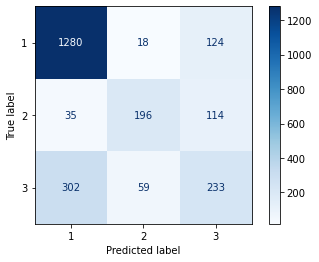

In [43]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=rf_uns_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_uns_classifier.classes_)
# disp.plot(cmap="PiYG")
disp.plot(cmap = 'Blues')
# disp.plot(cmap = 'viridis')

plt.show()

In [31]:
# True Introvert, True Entrovert, True Ambert
ti, fi1, fi2, fe1, te, fe2, fa1, fa2, ta = confusion_matrix(y_test, y_pred).ravel()
# accuracy = (tp + tn) / (tp + fp + tn + fn) 
accuracy = (ti + te +ta) / (ti + fi1 + fi2 + fe1 + te + fe2 + fa1 + fa2 + ta) 
print(f"Accuracy: {accuracy}")

Accuracy: 0.7238458280389666


In [32]:
# Calculate metrics for the Random Forest Classifier model based on unscaled data

y_pred = rf_uns_classifier.predict(X_test)

print('\nUNSCALED: Metrics of Random Forest Classifier Model')
print('------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='micro')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='micro')))

print('\nClassification Report')
print(classification_report(y_test, y_pred))


UNSCALED: Metrics of Random Forest Classifier Model
------------------------------------------------------
Accuracy = 0.72385
Precision = 0.72385
Recall = 0.72385
F1 score = 0.72385

Classification Report
              precision    recall  f1-score   support

           1       0.79      0.90      0.84      1422
           2       0.72      0.57      0.63       345
           3       0.49      0.39      0.44       594

    accuracy                           0.72      2361
   macro avg       0.67      0.62      0.64      2361
weighted avg       0.71      0.72      0.71      2361



In [33]:
print('\nUNSCALED: Metrics of Random Forest Classifier Model')
print('------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='macro')))

print('\nClassification Report')
print(classification_report(y_test, y_pred))


UNSCALED: Metrics of Random Forest Classifier Model
------------------------------------------------------
Accuracy = 0.72385
Precision = 0.66808
Recall = 0.62017
F1 score = 0.63808

Classification Report
              precision    recall  f1-score   support

           1       0.79      0.90      0.84      1422
           2       0.72      0.57      0.63       345
           3       0.49      0.39      0.44       594

    accuracy                           0.72      2361
   macro avg       0.67      0.62      0.64      2361
weighted avg       0.71      0.72      0.71      2361



In [34]:
# Calculate metrics for the Random Forest Classifier model based on unscaled data

y_pred = rf_uns_classifier.predict(X_test)

print('\nUNSCALED: Metrics of Random Forest Classifier Model')
print('------------------------------------------------------')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred,)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\nClassification Report')
print(classification_report(y_test, y_pred))


UNSCALED: Metrics of Random Forest Classifier Model
------------------------------------------------------
Accuracy = 0.72385
Precision = 0.70613
Recall = 0.72385
F1 score = 0.71013

Classification Report
              precision    recall  f1-score   support

           1       0.79      0.90      0.84      1422
           2       0.72      0.57      0.63       345
           3       0.49      0.39      0.44       594

    accuracy                           0.72      2361
   macro avg       0.67      0.62      0.64      2361
weighted avg       0.71      0.72      0.71      2361



In [35]:
# Scale the data

# adding import dependencies here again for my reference.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# Train a Random Forest Classifier model on the scaled data and print the model score
from sklearn.ensemble import RandomForestClassifier

rf_s_classifier = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print("----------------------------------------------")
print("Random Forest Classifier - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_s_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf_s_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Random Forest Classifier - Scaled Data
----------------------------------------------
Training Data Score: 1.0
Testing Data Score: 0.7229987293519695
----------------------------------------------


## Logistic Regression

In [37]:
# Train the Logistic Regression model on the unscaled data and print the model score
# adding import dependencies here again for my reference.
from sklearn.linear_model import LogisticRegression

lr_uns_classifier = LogisticRegression()
lr_uns_classifier.fit(X_train, y_train)

print("----------------------------------------------")
print("Logistic Regression - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lr_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Logistic Regression - Unscaled Data
----------------------------------------------
Training Data Score: 0.7765025041736227
Testing Data Score: 0.7259635747564591
----------------------------------------------


C:\Users\kesam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
# Train the Logistic Regression model on the scaled data and print the model score

# adding import dependencies here again for my reference.
from sklearn.linear_model import LogisticRegression

lr_s_classifier = LogisticRegression()
lr_s_classifier.fit(X_train_scaled, y_train)

print("----------------------------------------------")
print("Logistic Regression - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lr_s_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {lr_s_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Logistic Regression - Scaled Data
----------------------------------------------
Training Data Score: 0.7773372287145242
Testing Data Score: 0.7285048708174502
----------------------------------------------


## Multiple Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
lnr_uns_classifier = LinearRegression()

# Fitting our model with all our features in X
lnr_uns_classifier.fit(X_train, y_train)

print("----------------------------------------------")
print("Linear Regression - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lnr_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {lnr_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Linear Regression - Unscaled Data
----------------------------------------------
Training Data Score: 0.29771414306965005
Testing Data Score: 0.23095512862618128
----------------------------------------------


In [40]:
from sklearn.linear_model import LinearRegression
lnr_s_classifier = LinearRegression()

# Fitting our model with all our features in X
lnr_s_classifier.fit(X_train_scaled, y_train)

print("----------------------------------------------")
print("Linear Regression - Scaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {lnr_uns_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {lnr_uns_classifier.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

----------------------------------------------
Linear Regression - Scaled Data
----------------------------------------------
Training Data Score: -0.18858285304377498
Testing Data Score: -0.2028256166826352
----------------------------------------------


## Unsupervised Learning

In [ ]:
# Principal Component Analysis

from sklearn.decomposition import PCA

# Instead of providing the number of components while instantiating the PCA, by specifying the float number between 0.0 and 1.0. 
# This float value represents the ratio of variance you wish to preserve. Here I am setting the variance to 90%.

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_train_scaled)
X_pca

In [ ]:
# Ratio indicates the proportion of the dataset's variance that lies along each principal component.

pca.explained_variance_ratio_

In [ ]:
# Even though we did not explicitly provide the number of components in PCA, its calculated to be 74 to preserve 90% of the explained variance.

print(f"\nSum of explained variance: {np.sum(pca.explained_variance_ratio_)}")
print(f"Number of dimentsion required: {pca.n_components_}")

In [ ]:
# t-Distributed Stochastic Neighbor Embedding

from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=10, perplexity = 50)
transformed_features = tsne.fit_transform(X_pca)
transformed_features

In [ ]:
transformed_features.shape

In [ ]:
# Loading features into the dataframe

X['x'] = transformed_features[:,0]
X['IE'] = y_train
X['y'] = transformed_features[:,1]
X

In [ ]:
# Plot the feature output of the t-SNE reduction technique

plt.scatter(X['x'], X['y'], c=X['IE'])
plt.xticks(range(-50,60,10))
plt.yticks(range(-40,50,10))
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Scatter plot of t-SNE output')
# plt.savefig('../Images/Scatter-plot-of-t-SNE.png')
plt.show()

In [ ]:
# Finding the best value for _k_ using the Elbow Curve
from sklearn.cluster import KMeans

inertia = []
k = list(range(1, 11))

# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X_pca)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

In [ ]:
# Elbow curve to identify the best number of clusters

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot for k-Means Cluster Analysis')
# plt.savefig('../Images/Elbow-plot-k-Means-Cluster.png')
plt.show()

In [ ]:
# t-Distributed Stochastic Neighbor Embedding

from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=10, perplexity = 50)
transformed_features = tsne.fit_transform(X)
transformed_features

In [ ]:
transformed_features.shape

In [ ]:
# Loading features into the dataframe

X['x'] = transformed_features[:,0]
X['y'] = transformed_features[:,1]

# Plot the feature output of the t-SNE reduction technique

plt.scatter(X['x'], X['y'])
plt.xticks(range(-50,60,10))
plt.yticks(range(-40,50,10))
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Scatter plot of t-SNE output')
# plt.savefig('../Images/Scatter-plot-of-t-SNE.png')
plt.show()

In [ ]:
# Finding the best value for _k_ using the Elbow Curve
from sklearn.cluster import KMeans

inertia = []
k = list(range(1, 11))

# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

In [ ]:
# Elbow curve to identify the best number of clusters

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot for k-Means Cluster Analysis')
# plt.savefig('../Images/Elbow-plot-k-Means-Cluster.png')
plt.show()

## Supervised Learning - Optimization attempts

In [ ]:
# Train a Random Forest Classifier model and print the model score
# adding import dependencies here again for my reference.
from sklearn.ensemble import RandomForestClassifier

rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=1000, max_features=None, n_jobs=-1, max_depth=None, bootstrap=True).fit(X_train, y_train)
# rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=1000, max_features="sqrt", n_jobs=-1, max_depth=None, min_samples_split=2, bootstrap=False).fit(X_train, y_train)
# rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=50, max_leaf_nodes=16, n_jobs=-1).fit(X_train, y_train)
# restrict max_depth , try in 100 steps
# rf_uns_classifier = RandomForestClassifier(random_state=1, n_estimators=100, max_features=None, n_jobs=-1, max_depth=2, bootstrap=True).fit(X_train, y_train)


print("----------------------------------------------")
print("Random Forest Classifier - Unscaled Data")
print("----------------------------------------------")
print(f"Training Data Score: {rf_uns_classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_uns_classifier.score(X_test, y_test)}")
print("----------------------------------------------")

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators = 200, algorithm='SAMME.R', learning_rate=0.5
                            )
ada_clf.fit(X_train, y_train)

print(f"Training Data Score: {ada_clf.score(X_train, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test, y_test)}")
print("----------------------------------------------")

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators = 200, algorithm='SAMME.R', learning_rate=0.5
                            )
ada_clf.fit(X_train, y_train)

print(f"Training Data Score: {ada_clf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
                    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
                    n_estimators = 500, max_samples=1.0, bootstrap=True, n_jobs = -1
                        )

bag_clf.fit(X_train, y_train)

print(f"Training Data Score: {bag_clf.score(X_train, y_train)}")
print(f"Testing Data Score: {bag_clf.score(X_test, y_test)}")
print("----------------------------------------------")

bag_clf.fit(X_train_scaled, y_train)

print(f"Training Data Score: {bag_clf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {bag_clf.score(X_test_scaled, y_test)}")
print("----------------------------------------------")

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()

voting_clf=VotingClassifier(
                estimators=[('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                voting='hard')
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC(probability=True)

voting_clf=VotingClassifier(
                estimators=[('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                voting='soft')
voting_clf.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train_scaled,y_train)
    y_pred=clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf=BaggingClassifier(
            DecisionTreeClassifier(),n_estimators=500,
            bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train_scaled, y_train)
y_pred=bag_clf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))
print(bag_clf.oob_score_)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=520, learning_rate=0.1, warm_start=True)
gbrt.fit(X_train, y_train)

print(f"Training Data Score: {gbrt.score(X_train, y_train)}")
print(f"Testing Data Score: {gbrt.score(X_test, y_test)}")

errors = [mean_squared_error(y_test,y_pred)
         for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1
print(f"Best Estimators: {bst_n_estimators}")

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, learning_rate=0.1, loss='squared_error')
gbrt_best.fit(X_train, y_train)

print(f"Training Data Score: {gbrt_best.score(X_train, y_train)}")
print(f"Testing Data Score: {gbrt_best.score(X_test, y_test)}")